In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import tracker
import stats
import visualizer
import utils

from tqdm import trange

import importlib

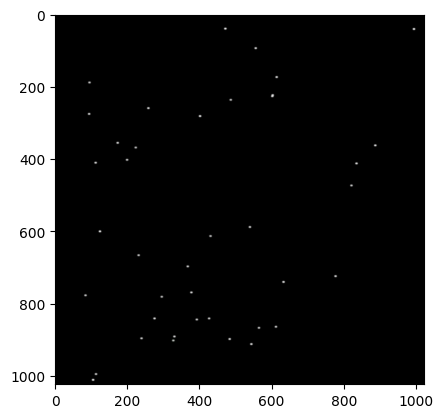

In [2]:
videofile = "ExampleVideos/synthetic40.mp4"

# Visualize the input
cap = cv2.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

plt.imshow(frame)

In [3]:
# Load groundtruth dataframe
df = utils.loadDataFrame("ExampleVideos/synthetic40.csv")

def compute_deltas(df_in):

    df = df_in.copy()

    # Compute delta_x and delta_y columns for each sperm id and frame
    for index, row in df.iterrows():
        if row['frame'] > 0:
            prev_row = df[(df['sperm'] == row['sperm']) & (df['frame'] == row['frame'] - 1)]
            if not prev_row.empty:
                df.at[index, 'delta_x'] = row['x'] - prev_row.iloc[0]['x']
                df.at[index, 'delta_y'] = row['y'] - prev_row.iloc[0]['y']
            else:
                df.at[index, 'delta_x'] = 0
                df.at[index, 'delta_y'] = 0
    else:
        df.at[index, 'delta_x'] = 0
        df.at[index, 'delta_y'] = 0

    return df

df = compute_deltas(df)

In [11]:
df.to_csv("ExampleVideos/synthetic40_with_deltas.csv", index=False)

### Train movement predictor

In [4]:
# Create sliding window forecast dataset

def create_sliding_window_dataset(df, window_size=5):
    X = []
    y = []

    for index, row in df.iterrows():
        if row['frame'] >= window_size:
            features = []
            for w in range(window_size):
                prev_row = df[(df['sperm'] == row['sperm']) & (df['frame'] == row['frame'] - w)]
                if not prev_row.empty:
                    features.extend([prev_row.iloc[0]['delta_x'], prev_row.iloc[0]['delta_y']])
                else:
                    features.extend([0, 0])
            X.append(features)
            y.append([row['delta_x'], row['delta_y']])

    return np.array(X), np.array(y)

X, y = create_sliding_window_dataset(df, window_size=5)

print(X.shape, y.shape) # Currently delta_x and delta_y are in the same dimension 

(10600, 10) (10600, 2)


In [5]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500)
model.fit(X, y)

MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500)

In [6]:
# Test set
test_df = utils.loadDataFrame("ExampleVideos/synthetic10.csv")
test_df = compute_deltas(test_df)
X_test, y_test = create_sliding_window_dataset(test_df, window_size=5)
predictions = model.predict(X_test)

# Evaluate the model
mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error on test set: {mse}")

Mean Squared Error on test set: 0.0026704383650263163


### Create forecasting based tracker

In [7]:
# Start with perfect detections for now
test_df = utils.loadDataFrame("ExampleVideos/synthetic40.csv")
test_df = test_df.drop(columns=['sperm']) # Remove sperm ids

def forecast_tracker(df, model, window_size=5, dist_cutoff=20, epsilon_cutoff=4):
    
    # Make sperm ids column
    df['sperm'] = -1  # Initialize sperm ids with -1

    # Iterate through each frame, try to link from previous frame
    max_frame = df['frame'].max()
    tracked_df = df[df['frame'] == 0].copy() # Start with first frame detections
    tracked_df['sperm'] = range(len(tracked_df)) # Assign initial sperm ids

    # While the window size is not met, match purely on distance
    for frame in range(1, window_size):
        prev_frame_df = tracked_df[tracked_df['frame'] == frame - 1].copy()
        curr_frame_df = df[df['frame'] == frame].copy()

        # Match based on nearest neighbor
        for index, row in curr_frame_df.iterrows():
            distances = np.sqrt((prev_frame_df['x'] - row['x'])**2 + (prev_frame_df['y'] - row['y'])**2)
            if not distances.empty:
                min_index = distances.idxmin()
                curr_frame_df.at[index, 'sperm'] = prev_frame_df.at[min_index, 'sperm']
        
        # Assign new sperm ids to unmatched detections
        unmatched = curr_frame_df[curr_frame_df['sperm'] == -1]
        next_sperm_id = tracked_df['sperm'].max() + 1
        for index, row in unmatched.iterrows():
            curr_frame_df.at[index, 'sperm'] = next_sperm_id
            next_sperm_id += 1
        
        tracked_df = pd.concat([tracked_df, curr_frame_df], ignore_index=True)

    # Once the window size is met, use the model to predict next positions
    for frame in range(window_size, max_frame + 1):
        prev_frame_df = tracked_df[tracked_df['frame'] == frame - 1].copy()
        curr_frame_df = df[df['frame'] == frame].copy()

        # Create the sliding window for each sperm in previous frames
        for sperm in prev_frame_df['sperm'].unique():
            rows = []
            for w in range(0, window_size):
                cur_row = tracked_df[(tracked_df['sperm'] == sperm) & (tracked_df['frame'] == frame - w)]
                prev_row = tracked_df[(tracked_df['sperm'] == sperm) & (tracked_df['frame'] == frame - w - 1)]
                if not prev_row.empty and not cur_row.empty:
                    delta_x = cur_row.iloc[0]['x'] - prev_row.iloc[0]['x']
                    delta_y = cur_row.iloc[0]['y'] - prev_row.iloc[0]['y']
                    rows.append([delta_x, delta_y])
                else:
                    rows.append([0,0])
            sperm_window = np.array(rows).flatten().reshape(1, -1)
            
            # Predict next delta_x and delta_y
            predicted_deltas = model.predict(sperm_window)
            # Update the last known position of the sperm
            last_pos = tracked_df[(tracked_df['sperm'] == sperm) & (tracked_df['frame'] == frame - 1)].iloc[0]
            new_x = last_pos['x'] + predicted_deltas[0][0]
            new_y = last_pos['y'] + predicted_deltas[0][1]

            # Find the nearest detection in the current frame to the predicted position
            distances = np.sqrt((curr_frame_df['x'] - new_x)**2 + (curr_frame_df['y'] - new_y)**2)
            if not distances.empty:
                min_index = distances.idxmin()
                if distances[min_index] < dist_cutoff:  # Threshold to consider a match
                    if curr_frame_df.at[min_index, 'sperm'] == -1:  # Only assign if not already assigned
                        curr_frame_df.at[min_index, 'sperm'] = sperm
                    else:
                        # Create a new row for with this location copied but new sperm id
                        curr_frame_df = pd.concat([curr_frame_df, pd.DataFrame({
                            'frame': [frame],
                            'x': [curr_frame_df.at[min_index, 'x']],
                            'y': [curr_frame_df.at[min_index, 'y']],
                            'sperm': [sperm]
                        })], ignore_index=True)
            
        # Assign new sperm ids to unmatched detections
        unmatched = curr_frame_df[curr_frame_df['sperm'] == -1]
        next_sperm_id = tracked_df['sperm'].max() + 1
        remove_indices = []
        for index, row in unmatched.iterrows():
            # If the detection is far from all predicted positions, assign new id
            distances = []
            x = row['x']
            y = row['y']
            for sperm in curr_frame_df['sperm'].unique():
                if sperm != -1:
                    pos = curr_frame_df[curr_frame_df['sperm'] == sperm]
                    dist = np.sqrt((x - pos['x'])**2 + (y - pos['y'])**2).values
                    distances.append(dist)
            if distances and min(distances) > epsilon_cutoff:
                curr_frame_df.at[index, 'sperm'] = next_sperm_id
                next_sperm_id += 1
            else:
                remove_indices.append(index)

        curr_frame_df = curr_frame_df.drop(remove_indices)
        tracked_df = pd.concat([tracked_df, curr_frame_df], ignore_index=True)

    return tracked_df

tracked_df = forecast_tracker(test_df, model, window_size=5)
print(tracked_df)

       frame           x           y  sperm
0          0  601.327884  227.549626      0
1          0  275.155018  842.617008      1
2          0  426.934511  842.819802      2
3          0  377.818236  770.007042      3
4          0  776.761917  725.331055      4
...      ...         ...         ...    ...
11603    269  287.526150  275.078978     37
11604    269  203.630960  943.924890     68
11605    269  287.526150  275.078978     41
11606    269  524.128955   89.950680     44
11607    269  524.128955   89.950680     30

[11608 rows x 4 columns]


In [8]:
# Plot tracks
videofile = "ExampleVideos/synthetic40.mp4"
visualizer.runVisualization(videofile, tracked_df)

(85, 3)
Video Finished.
